# Classify the flowers shown in the flower dataset

* The flowers are in color and you'll have to work with that. You can't turn them to greyscale etc.
* Data augmentation is allowed here due to popular complaint, but the problem can be completed without it




In [1]:
# Importing the libraries
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets,models, transforms
import time
import sys
# !pip install torchsummary 
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import random


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading the Training and Testing Data using Data Loader with Data Augmentation



In [3]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [4]:
# # # Dataset 1: Final abdomen images
# TRAIN_PATH1 = ['../allabdomen/train/skin_train2019/']
# MASK_PATH1 = ['../allabdomen/train/annotations/']
# train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
# mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
# train_ids1.sort()
# mask_ids1.sort()
# TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
# MASK_PATH1 = MASK_PATH1*len(train_ids1)

# # # Dataset 2: Augmented Abdomen Images
# TRAIN_PATH2 = ['../allabdomen/train/skin_augmented/']
# MASK_PATH2 = ['../allabdomen/train/annotations_augmented/']
# train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
# mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
# train_ids2.sort()
# mask_ids2.sort()
# TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
# MASK_PATH2 = MASK_PATH2*len(train_ids2)

# # # Combine everything
# TRAIN_PATH = np.concatenate((TRAIN_PATH1,TRAIN_PATH2))
# MASK_PATH = np.concatenate((MASK_PATH1,MASK_PATH2))
# train_ids = np.concatenate((train_ids1,train_ids2))
# mask_ids = np.concatenate((mask_ids1,mask_ids2))


# # Get and resize train images and masks DONT RUN IN THIS CODE
# X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
# print('Getting and resizing train images and masks ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
#     path = TRAIN_PATH[n] + id_
#     img = imread(path)[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_train[n] = img

# for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
#     path = MASK_PATH[n] + id_
#     img = imread(path)
#     #if n in range(899,977):
#         #img = img[:,:,1]
#     img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True), axis=-1)
#     Y_train[n] = img

In [5]:
# # Check if training data looks all right
# ix = random.randint(0, len(train_ids))
# imshow(X_train[ix])
# plt.show()
# # imshow(np.squeeze(Y_train[436]))
# imshow(Y_train[ix][:,:,0])
# plt.show()

In [6]:
# # Saving the Loaded train np arrays
# np.save('X_train.npy',X_train)
# np.save('Y_train.npy',Y_train)

In [7]:
# Loading the Training and Testing Data
trainImages = np.load('X_train.npy')
trainLabels = np.load('Y_train.npy')
# Splitting the Data into Training and Test Data
X_train, X_test,Y_train,Y_test = train_test_split(trainImages,trainLabels, test_size=0.15, shuffle = True)

# Finding the mean and the Variance
img_mean = np.mean(np.swapaxes(trainImages/255.0,0,1).reshape(3, -1), 1)
img_std = np.std(np.swapaxes(trainImages/255.0,0,1).reshape(3, -1), 1)
print("mean: {}, std: {}".format(img_mean, img_std))


mean: [0.53766632 0.55240142 0.52007403], std: [0.27631814 0.25418144 0.28067154]


In [8]:
class FlowerLoader(torch.utils.data.Dataset):
    def __init__(self, x_arr, y_arr, transform=None):
        self.x_arr = x_arr
        self.y_arr = y_arr
        self.transform = transform

    def __len__(self):
        return self.x_arr.shape[0]

    def __getitem__(self, index):
        img = self.x_arr[index]
        label = self.y_arr[index]
        if self.transform is not None:
            img = self.transform(img)

        return img, label

## Normalizing about mean and variance
* Also defining Train and Test Data Loaders
* Train Data Loader has shuffle = True; This will ensure that every epoch the data in each minibatch will be shuffled, which ideal to prevent overfitting.
* MiniBatch of 64 is chosen, as Testing accuracy ranges around 74 -78 percent with other sizes like 128 or 256.
* Data Augmentation is enabled for train loader again to decrease overfitting.
* For Test Loader only the normalized parameter is used. This is to ensure that we get the right accuracy. 

In [9]:
## Normalizing the Data
normalize = transforms.Normalize(mean=list(img_mean),std=list(img_std))
batch_size =64

train_loader = torch.utils.data.DataLoader(
    FlowerLoader(X_train, Y_train, transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=True)
# remove augmentation transforms in test loader
test_loader = torch.utils.data.DataLoader(
    FlowerLoader(X_test, Y_test, transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        normalize,
    ])), 
      batch_size=batch_size,shuffle=False)

# Showing the Input Data 
* Dint use Pytorch to show data as, I already had code written using numpy

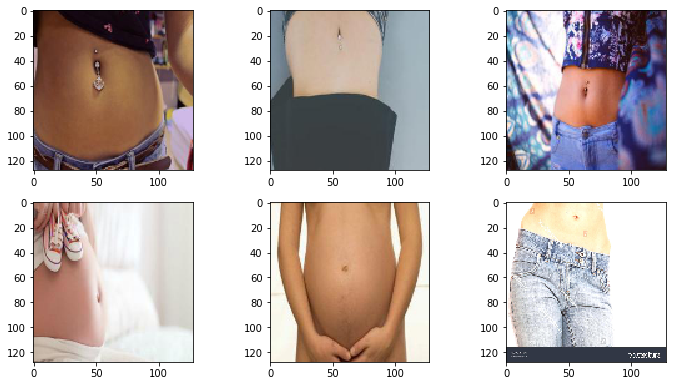

In [10]:
# Preview the training data
plt.figure(figsize=(12,10))# Showing the Input Data after Normalizing
x, y = 3, 3
for i in range(6):  
    plt.subplot(y, x, i+1)
    plt.imshow(trainImages[i],interpolation='nearest')
plt.show()

## Defining Convolution Neural Network
* Initially I tried using 2 and 3 layer convolutions with dropout(0.5) and batchregularization, but the accuracy varied between 69 - (75, 77 ) percent. After taking suggestions from comments on Piazza, I tried implementing VGG.
* After Implementing different VGG Networks, VGG13 gave the best results. 
* I modified the original network to increase accuracy from 80 to 83 percent. This was due to changing the activation function and using dropouts.


In [22]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(67, 128)
#         self.relu1 = nn.ReLU()
#         self.dout = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(128, 64)
#         self.relu2 = nn.ReLU()
#         self.dout2 = nn.Dropout(0.2)
#         self.fc3 = nn.Linear(64, 32)
#         self.prelu = nn.PReLU(1)
#         self.out = nn.Linear(32, 1)
#         self.out_act = nn.Sigmoid()
    
#     def swish(self,x):
#         return x * torch.sigmoid(x)
        
#     def forward(self, input_):
#         inp = self.fc1(input_)
#         x = self.relu1(inp)
#         x = self.dout(x)
#         x = self.fc2(x)
#         x = self.relu2(x)
#         x = self.dout2(x)
#         x = self.fc3(x)
#         x = self.prelu(x)
#         x = self.out(x)
#         y = (self.out_act(x))
#         return y
# net = Net()
# net.to(device)

Net(
  (fc1): Linear(in_features=67, out_features=128, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dout2): Dropout(p=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (prelu): PReLU(num_parameters=1)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [28]:
class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)


class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.enc1 = _EncoderBlock(3, 64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512, dropout=True)
        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4 = _DecoderBlock(1024, 512, 256)
        self.dec3 = _DecoderBlock(512, 256, 128)
        self.dec2 = _DecoderBlock(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        initialize_weights(self)
    def initialize_weights(*models):
        for model in models:
            for module in model.modules():
                if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                    nn.init.kaiming_normal(module.weight)
                    if module.bias is not None:
                        module.bias.data.zero_()
                elif isinstance(module, nn.BatchNorm2d):
                    module.weight.data.fill_(1)
                    module.bias.data.zero_()

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.upsample(enc4, center.size()[2:], mode='bilinear')], 1))
        dec3 = self.dec3(torch.cat([dec4, F.upsample(enc3, dec4.size()[2:], mode='bilinear')], 1))
        dec2 = self.dec2(torch.cat([dec3, F.upsample(enc2, dec3.size()[2:], mode='bilinear')], 1))
        dec1 = self.dec1(torch.cat([dec2, F.upsample(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        return F.upsample(final, x.size()[2:], mode='bilinear')

In [33]:
net = UNet
# net.load_state_dict
# net.to(device)
# summary(net,(3,227,227),batch_size=batch_size)

In [ ]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x



In [38]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)
    
net = UNet
net.to(device)

AttributeError: 'torch.device' object has no attribute '_apply'

In [13]:
# Code Modified from  https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
config = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512 ,512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128,'D', 128, 'M', 256,'D', 256, 256, 256, 'M', 512,'D', 512, 512, 512, 'M', 512,'D', 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.conv = self._make_layers(config[vgg_name])
        self.linear = self._make_layers_linear()

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def vis(self, x):
        out = self.conv(x)
        return out
    
    def swish(self,x):
        return x * torch.sigmoid(x) # Tried using this, but as the error did not converge, not used later on.

    def _make_layers(self, config):
        layers = []
        in_channels = 3
        for x in config:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] 
            elif x == 'D':
                layers+= [nn.Dropout(0.5)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # Padding is adjusted 
                                                                               # To presever spatial dimension. 
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]#inplace=True, PReLU()
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    def _make_layers_linear(self):
        layers = []
#         layers +=[nn.Linear(512, 256)]
#         layers+= [nn.Dropout(0.5)]
        layers += [nn.Linear(512, 5)]
#         layers += [nn.LogSoftmax()]
#         layers += [nn.Linear(64, 5)]
        return nn.Sequential(*layers) # Try softmax here

net = VGG('VGG13')
net.to(device)

VGG(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), st

In [ ]:
# If want to get a summary of the network uncomment the below line as well as the one in importing libraries.
summary(net,(3,32,32),batch_size=batch_size)

## Explanations for Network Architecture

* The Loss function used is cross entropy class as there are multiple classes (5)
* The model architecture adopted was that of VGG 13. This is because: 
     * the accuracy was in the range of 64 – 71 percent with a 5 layer network (input – conv1 – conv2- linear - crossentropyloss) .
    * Convolutions were used as the input is 2D images. 
    * Even after adding dropouts of 0.2 and 0.5 in between the convolution layers the accuracy did not improve.
     * Conclusion: as the networks needs to learn RGB images and distinguish 5 labels, it will need more parameters to shatter the input space.  Also the images are very blurry, this adds on to the number of parameters needed as differentiating becomes more difficult.
* VGG 11 also did not give accuracies above 75 percent. As I was able to get descent accuracy with Vgg 13, I did not experiment with this network.
* The Optimizer with Vgg13 is taken as Adam, as it got me better accuracies than SGD. This may be because Adam is able to avoid local minima and does not get stuck. 
* Learning rate of 0.002 gets me a good error convergence graph. Increase the learning rate to 0.01 also gives similar results much faster, but then convergence graph is like a step function and therefore avoided.
* Some other experimentation with dropouts and different activations like (swish, relu and Prelu) can be seen in the screen shot of the excel file I made in the Ipython Notebook.
* Each filter or weights of the convolution layers is visualized, in the image shown below.
    * The image is a representation of weights of the first kernel in each layer (only a depth size of 3 is visualized for each convolution layer)
    * we can see that the weights initialized is different for each layer. ( as they have different colors).


## Visualizaing Weights

In [24]:
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0:3])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        break

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

Showing the weights of the first kernel in each convolution layer
(64, 3, 3, 3)


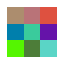

(64, 64, 3, 3)


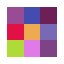

(128, 64, 3, 3)


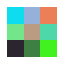

(128, 128, 3, 3)


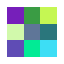

(256, 128, 3, 3)


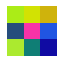

(256, 256, 3, 3)


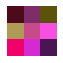

(512, 256, 3, 3)


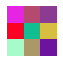

(512, 512, 3, 3)


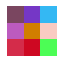

(512, 512, 3, 3)


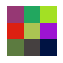

(512, 512, 3, 3)


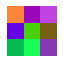

In [25]:
visnet = VGG('VGG13')
visnet = visnet.to('cpu').double()
print("Showing the weights of the first kernel in each convolution layer")
for m in visnet.modules():
    if isinstance(m, nn.Conv2d):   
        a = m.weight.data.numpy()
#         print(tensor.max())
        c = (a - np.min(a))/np.ptp(a).astype(float)
        print(c.shape)
        plot_kernels(c)
#         break


##  Define a Loss function and optimizer
* Cross Entropy Loss is used as there are multiiple classes (5). 
* Different Permuation of the learning rate and optimizers were tried. The table I created for getting intition for accuracy and error can be found below or attached with homework sumission.
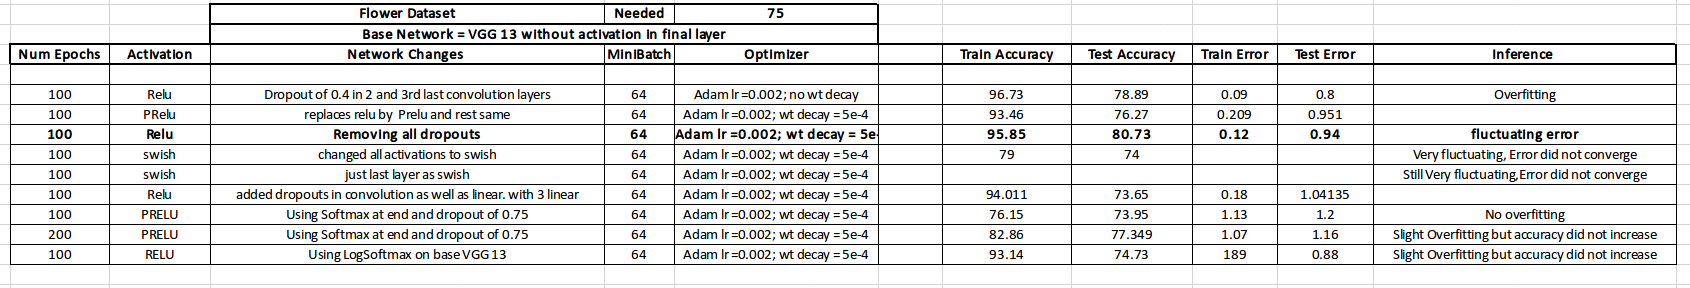
* After all the experimentation, the original vgg 13 network worked the best. Adding dropouts did not help, I guess this is due to not adding them at the right position. I also tried increasing the fully connected layers but it did not help.
* The most significant discrepancy was found that, when not using softmax layer or log softmax layer, the testing accuracy actually came out to be more. I dont know why this happened!!! 

In [37]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() 
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay = 5e-4)
optimizer = optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]

TypeError: parameters() missing 1 required positional argument: 'self'

In [ ]:
# For Debugging
# for batch_idx, (data, target) in enumerate(train_loader):
#     data, target = data.to(device), target.to(device)
#     output = net(data)
# # #         print(target.dtype,output.dtype)
#     loss = criterion(output, target)
#     # loss.backward()
#     # optimizer.step()
#     break
# target

## Training and Testing Functions

In [ ]:
def train(model, train_loader, optimizer, epoch,device):
#     print(criterion)
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        #==== Forward Pass=====
        output = model(data)
        loss = criterion(output, target)
        #=====Backward Pass=======
        loss.backward()
        optimizer.step()
        #=== Loss Append to get loss of entire Batch====
        lo.append(loss.item())
        #==== Calculating Training Accuracy========= 
        train_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += train_pred.eq(target.view_as(train_pred)).sum().item()
        #======= Logging results after every 20th batch============ 
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    #======== Getting Accuracy of the entire epoch by averaging of each batch===========    
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    #======== Getting Training Loss of the epoch by averaging across each batch
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    test_loss = 0
    correct = 0
    testlo = []
    with torch.no_grad(): # as we dont need to backpropogate when calculating testing error and accuracy
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #==== Getting the Prediction======
            output = model(data)
            #===== Calculating the Loss=========
            test_loss = criterion(output, target)
            testlo.append(test_loss.item())
            # Calculating Testing Accuracy for the all inputs=========
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    #======= Getting Testing Accuracy for the Epoch========
    test_accu.append(100. * correct / len(test_loader.dataset))
    #====== Getting Testing Error of Epoch========
    val_loss.append(np.mean(testlo))
   #======= Logging results after every epoch ============ 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(testlo), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
device

# Training the Model

In [ ]:
net.to(device)
epochs = 100
for epoch in range(1, epochs + 1):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

In [ ]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', np.mean(val_loss))
print('Testing Accuracy:', np.max(test_accu))
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss ' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(np.max(test_accu)))
plt.legend()
plt.show()

## Inferences
* It is clear from the abive graph that, there is overfitting in the network.
* I tried different menthods like changing dropouts and actiavtion functions to do address this.
* This did not help as, even though the overfitting decreased the final test accuracy always decreased.
* Adam gave beteer performance than SGD.
* The haphazard motion of both error and accuracy is due to the random shuffling of data in minibatches after each epoch.

# Incorrect Predictions


In [ ]:
err=[]
ind=[]
predictedlabel=[]
targetlabel=[]
n = 6   # Number of False predictions to output


vis_loader = torch.utils.data.DataLoader(
    FlowerLoader(X_test, Y_test, transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        normalize,
    ])), shuffle=False)

for data, target in vis_loader:
    data, target = data.to(device), target.to(device)
    #==== Getting the Prediction======
    output = net(data)
    #===== Calculating the Loss=========
    test_loss = criterion(output, target)
    err.append(test_loss.item())
    # Checking what predictions are correct========
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    predictedlabel.append(pred.item())
    targetlabel.append(target.item())
    neg = ~pred.eq(target.view_as(pred))
    ind.append(neg.item())
    
    
ind,err,predictedlabel,targetlabel =np.asarray(ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]

#======= Plotting Incorrect=======
num = 0
nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(X_test[maxerrorind[num]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(predictedlabel[[maxerrorind[row+col]]],
                                                                               targetlabel[[maxerrorind[row+col]]]))
        num+=1
fig.tight_layout()


## Correct Predictions

In [ ]:
#======= Plotting Correct=======

ind,err,predictedlabel,targetlabel =np.asarray(~ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]


nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
num =0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(X_test[maxerrorind[num]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(predictedlabel[[maxerrorind[row+col]]],
                                                                               targetlabel[[maxerrorind[row+col]]]))
        num+=1
fig.tight_layout()